# What is the notebook about?

## Problem - Taxi Environment Algorithms
This problem deals with a taxi environment and stochastic actions. The tasks you have to do are:
- Implement Policy Iteration
- Implement Modified Policy Iteration
- Implement Value Iteration
- Implement Gauss Seidel Value Iteration
- Visualize the results
- Explain the results

## How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved.**You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data. This should be an absolute path.
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [1]:
!pip install aicrowd-cli > /dev/null 

# AIcrowd Runtime Configuration 🧷

Get login API key from https://www.aicrowd.com/participants/me

In [2]:
import os

AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip")
AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")


API Key valid
Saved API Key successfully!
13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip: 100% 31.2k/31.2k [00:00<00:00, 262kB/s]


In [4]:
!unzip $AICROWD_DATASET_PATH

Archive:  /content/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip
replace inputs/inputs_base.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: inputs/inputs_base.npy  
  inflating: inputs/inputs_1.npy     
  inflating: inputs/inputs_0.npy     
  inflating: inputs/inputs_2.npy     
  inflating: targets/targets_2.npy   
  inflating: targets/targets_0.npy   
  inflating: targets/targets_1.npy   
  inflating: targets/targets_base.npy  


In [5]:
DATASET_DIR = 'inputs/'

## Taxi Environment

Read the environment to understand the functions, but do not edit anything

In [6]:
import numpy as np

class TaxiEnv_HW2:
    def __init__(self, states, actions, probabilities, rewards, initial_policy):
        self.possible_states = states
        self._possible_actions = {st: ac for st, ac in zip(states, actions)}
        self._ride_probabilities = {st: pr for st, pr in zip(states, probabilities)}
        self._ride_rewards = {st: rw for st, rw in zip(states, rewards)}
        self.initial_policy = initial_policy
        self._verify()

    def _check_state(self, state):
        assert state in self.possible_states, "State %s is not a valid state" % state

    def _verify(self):
        """ 
        Verify that data conditions are met:
        Number of actions matches shape of next state and actions
        Every probability distribution adds up to 1 
        """
        ns = len(self.possible_states)
        for state in self.possible_states:
            ac = self._possible_actions[state]
            na = len(ac)

            rp = self._ride_probabilities[state]
            assert np.all(rp.shape == (na, ns)), "Probabilities shape mismatch"
        
            rr = self._ride_rewards[state]
            assert np.all(rr.shape == (na, ns)), "Rewards shape mismatch"

            assert np.allclose(rp.sum(axis=1), 1), "Probabilities don't add up to 1"

    def possible_actions(self, state):
        """ Return all possible actions from a given state """
        self._check_state(state)
        return self._possible_actions[state]

    def ride_probabilities(self, state, action):
        """ 
        Returns all possible ride probabilities from a state for a given action
        For every action a list with the returned with values in the same order as self.possible_states
        """
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_probabilities[state][ac_idx]

    def ride_rewards(self, state, action):
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_rewards[state][ac_idx]

## Example of Environment usage

In [7]:
def check_taxienv():
    # These are the values as used in the pdf, but they may be changed during submission, so do not hardcode anything

    states = ['A', 'B', 'C']

    actions = [['1','2','3'], ['1','2'], ['1','2','3']]

    probs = [np.array([[1/2,  1/4,  1/4],
                    [1/16, 3/4,  3/16],
                    [1/4,  1/8,  5/8]]),

            np.array([[1/2,   0,     1/2],
                    [1/16,  7/8,  1/16]]),

            np.array([[1/4,  1/4,  1/2],
                    [1/8,  3/4,  1/8],
                    [3/4,  1/16, 3/16]]),]

    rewards = [np.array([[10,  4,  8],
                        [ 8,  2,  4],
                        [ 4,  6,  4]]),

            np.array([[14,  0, 18],
                        [ 8, 16,  8]]),

            np.array([[10,  2,  8],
                        [6,   4,  2],
                        [4,   0,  8]]),]
    initial_policy = {'A': '1', 'B': '1', 'C': '1'}

    env = TaxiEnv_HW2(states, actions, probs, rewards, initial_policy)
    print("All possible states", env.possible_states)
    print("All possible actions from state B", env.possible_actions('B'))
    print("Ride probabilities from state A with action 2", env.ride_probabilities('A', '2'))
    print("Ride rewards from state C with action 3", env.ride_rewards('C', '3'))

    base_kwargs = {"states": states, "actions": actions, 
                "probabilities": probs, "rewards": rewards,
                "initial_policy": initial_policy}
    return base_kwargs

base_kwargs = check_taxienv()
env = TaxiEnv_HW2(**base_kwargs)

All possible states ['A', 'B', 'C']
All possible actions from state B ['1', '2']
Ride probabilities from state A with action 2 [0.0625 0.75   0.1875]
Ride rewards from state C with action 3 [4 0 8]


## Task 1 - Policy Iteration
Run policy iteration on the environment and generate the policy and expected reward

In [8]:
# 1.1 Policy Iteration
def policy_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    while True :
        while True :
            delta = 0
            for state in taxienv.possible_states :
                J = values[state]
                action = policy[state]
                probabs = taxienv.ride_probabilities(state, action)
                rewards = taxienv.ride_rewards(state, action)
                sum = 0
                for k in range(len(probabs)) :
                    sum += probabs[k] * (rewards[k] + gamma * values[taxienv.possible_states[k]])
                values[state] = sum
                delta = max(delta, abs(J - values[state]))
            if delta < 1e-8 : 
                break
        done = 1
        for state in taxienv.possible_states :
            B = policy[state]
            temp_array = []
            for action in taxienv.possible_actions(state) :
                probabs = taxienv.ride_probabilities(state, action)
                rewards = taxienv.ride_rewards(state, action)
                sum = 0
                for k in range(len(probabs)) :
                    sum += probabs[k] * (rewards[k] + gamma * values[taxienv.possible_states[k]])
                temp_array.append(sum)
            policy[state] = taxienv.possible_actions(state)[np.argmax(temp_array)]
            if policy[state] != B :
                done = 0;
        if done == 1 : 
            break
    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    """
    # Code for printing results 
    string = ""
    for key in results.keys() :
        string += "| $\gamma$ = " + str(key) + " | A | B | C |" + "\n"
        string += "|---|---|---|---|\n"
        for key1 in results[key]['Expected Reward'].keys() :
            value = results[key]['Expected Reward'][key1]
            results[key]['Expected Reward'][key1] = round(value, 3)
        string += "| Expected Reward |" + str(results[key]['Expected Reward']['A']) + "|" + str(results[key]['Expected Reward']['B']) + "|" + str(results[key]['Expected Reward']['C']) + "|\n"
        string += "| Policy |" + str(results[key]['Policy']['A']) + "|" + str(results[key]['Policy']['B']) + "|" + str(results[key]['Policy']['C']) + "|\n\n___\n\n"
    print(string)
             
    """
    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 2 - Policy Iteration for multiple values of gamma

Ideally this code should run as is

In [9]:
# 1.2 Policy Iteration with different values of gamma
def run_policy_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = policy_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_policy_iteration(env)

# Task 3 - Modifed Policy Iteration

Implement modified policy iteration (where Value iteration is done for fixed m number of steps)

In [10]:
# 1.3 Modified Policy Iteration
def modified_policy_iteration(taxienv, gamma, m):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    H = {s: 0 for s in states}
    while True : 
        for k in range(m) :
            for state in taxienv.possible_states : 
                temp_array = []
                for action in taxienv.possible_actions(state) : 
                    rewards = taxienv.ride_rewards(state, action)
                    probabs = taxienv.ride_probabilities(state, action)
                    sum = 0
                    for i in range(len(probabs)) :
                        sum += probabs[i] * (rewards[i] + gamma * values[taxienv.possible_states[i]])
                    temp_array.append(sum)
                H[state] = max(temp_array)
            for state in taxienv.possible_states : 
                values[state] = H[state]
        done = 1
        for state in taxienv.possible_states : 
            B = policy[state]
            temp_array = []
            for action in taxienv.possible_actions(state) :
                rewards = taxienv.ride_rewards(state, action)
                probabs = taxienv.ride_probabilities(state, action)
                sum = 0
                for i in range(len(probabs)) :
                    sum += probabs[i] * (rewards[i] + gamma * values[taxienv.possible_states[i]])
                temp_array.append(sum)
            policy[state] = taxienv.possible_actions(state)[np.argmax(temp_array)]
            if policy[state] != B :
                done = 0
        if done == 1 : 
            break
    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ## Do not edit below this line


    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 4 Modified policy iteration for multiple values of m

Ideally this code should run as is

In [11]:
def run_modified_policy_iteration(env):
    m_values = np.arange(1, 15)
    gamma = 0.9
    results, extra_info = {}, {}
    for m in m_values:
        results[m], extra_info[m] = modified_policy_iteration(env, gamma, m)
    return results, extra_info

results, extra_info = run_modified_policy_iteration(env)

# Task 5 Value Iteration

Implement value iteration and find the policy and expected rewards

In [12]:
# 1.4 Value Iteration
def value_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf
    H = {s: 0 for s in states}
    values_dict = {}
    iteration = 0
    while True : 
        delta = 0
        for state in taxienv.possible_states : 
            temp_array = []
            for action in taxienv.possible_actions(state) : 
                rewards = taxienv.ride_rewards(state, action)
                probabs = taxienv.ride_probabilities(state, action)
                sum = 0
                for i in range(len(probabs)) :
                    sum += probabs[i] * (rewards[i] + gamma * values[taxienv.possible_states[i]])
                temp_array.append(sum)
            H[state] = max(temp_array)
            delta = max(delta, abs(H[state] - values[state]))
        for state in taxienv.possible_states : 
            values[state] = H[state]
            values_dict[iteration] = values.copy()
        if delta < 1e-8 :
            break
        iteration += 1

    for state in taxienv.possible_states : 
        temp_array = []
        for action in taxienv.possible_actions(state) :
            rewards = taxienv.ride_rewards(state, action)
            probabs = taxienv.ride_probabilities(state, action)
            sum = 0
            for i in range(len(probabs)) :
                sum += probabs[i] * (rewards[i] + gamma * values[taxienv.possible_states[i]])
            temp_array.append(sum)
        policy[state] = taxienv.possible_actions(state)[np.argmax(temp_array)]

    # Put your extra information needed for plots etc in this dictionary
    extra_info = {'Values_Dict': values_dict}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 6 Value Iteration with multiple values of gamma

Ideally this code should run as is

In [13]:
def run_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = value_iteration(env, gamma)
    return results, extra_info
  
results, extra_info = run_value_iteration(env)

# Task 7 Gauss Seidel Value Iteration

Implement Gauss Seidel Value Iteration

In [14]:
# 1.4 Gauss Seidel Value Iteration
def gauss_seidel_value_iteration(taxienv, gamma):
    # A list of all the states
    # For Gauss Seidel Value Iteration - iterate through the values in the same order
    states = taxienv.possible_states

    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    # Hints - 
    # Do not hardcode anything
    # For Gauss Seidel Value Iteration - iterate through the values in the same order as taxienv.possible_states
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    ## Begin code here
    iteration = 0
    values_dict = {}
    while True : 
        delta = 0 
        for state in taxienv.possible_states : 
            J = values[state]
            temp_array = []
            for action in taxienv.possible_actions(state) :
                rewards = taxienv.ride_rewards(state, action)
                probabs = taxienv.ride_probabilities(state, action)
                sum = 0
                for i in range(len(probabs)) :
                    sum += probabs[i] * (rewards[i] + gamma * values[taxienv.possible_states[i]])
                temp_array.append(sum)
            values[state] = max(temp_array)
            delta = max(delta, abs(J - values[state]))
        values_dict[iteration] = values.copy()
        if delta < 1e-8 :
            break
        iteration += 1
    
    for state in taxienv.possible_states :
        temp_array = []
        for action in taxienv.possible_actions(state) :
            rewards = taxienv.ride_rewards(state, action)
            probabs = taxienv.ride_probabilities(state, action)
            sum = 0
            for i in range(len(probabs)) :
                sum += probabs[i] * (rewards[i] + gamma * values[taxienv.possible_states[i]])
            temp_array.append(sum)
        policy[state] = taxienv.possible_actions(state)[np.argmax(temp_array)]
    # Put your extra information needed for plots etc in this dictionary


    extra_info = {'Values_Dict' : values_dict}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 8 Gauss Seidel Value Iteration with multiple values of gamma

Ideally this code should run as is

In [15]:
def run_gauss_seidel_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = gauss_seidel_value_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_gauss_seidel_value_iteration(env)

# Generate Results ✅

In [16]:
# Do not edit this cell
def get_results(kwargs):

    taxienv = TaxiEnv_HW2(**kwargs)

    policy_iteration_results = run_policy_iteration(taxienv)[0]
    modified_policy_iteration_results = run_modified_policy_iteration(taxienv)[0]
    value_iteration_results = run_value_iteration(taxienv)[0]
    gs_vi_results = run_gauss_seidel_value_iteration(taxienv)[0]

    final_results = {}
    final_results["policy_iteration"] = policy_iteration_results
    final_results["modifed_policy_iteration"] = modified_policy_iteration_results
    final_results["value_iteration"] = value_iteration_results
    final_results["gauss_seidel_iteration"] = gs_vi_results

    return final_results

In [17]:
# Do not edit this cell, generate results with it as is
if not os.path.exists(AICROWD_RESULTS_DIR):
    os.mkdir(AICROWD_RESULTS_DIR)

for params_file in os.listdir(DATASET_DIR):
  kwargs = np.load(os.path.join(DATASET_DIR, params_file), allow_pickle=True).item()
  results = get_results(kwargs)
  idx = params_file.split('_')[-1][:-4]
  np.save(os.path.join(AICROWD_RESULTS_DIR, 'results_' + idx), results)

# Check your local score

This score is not your final score, and it doesn't use the marks weightages. This is only for your reference of how arrays are matched and with what tolerance.

In [18]:
# Check your score on the given test cases (There are more private test cases not provided)
target_folder = 'targets'
result_folder = AICROWD_RESULTS_DIR

def check_algo_match(results, targets):
    param_matches = []
    for k in results:
        param_results = results[k]
        param_targets = targets[k]
        policy_match = param_results['Policy'] == param_targets['Policy']
        rv = [v for k, v in param_results['Expected Reward'].items()]
        tv = [v for k, v in param_targets['Expected Reward'].items()]
        rewards_match = np.allclose(rv, tv, rtol=3)
        equal = rewards_match and policy_match
        param_matches.append(equal)
    return np.mean(param_matches)

def check_score(target_folder, result_folder):
    match = []
    for out_file in os.listdir(result_folder):
        res_file = os.path.join(result_folder, out_file)
        results = np.load(res_file, allow_pickle=True).item()
        idx = out_file.split('_')[-1][:-4]  # Extract the file number
        target_file = os.path.join(target_folder, f"targets_{idx}.npy")
        targets = np.load(target_file, allow_pickle=True).item()
        algo_match = []
        for k in targets:
            algo_results = results[k]
            algo_targets = targets[k]
            algo_match.append(check_algo_match(algo_results, algo_targets))
        match.append(np.mean(algo_match))
    return np.mean(match)

if os.path.exists(target_folder):
    print("Shared data Score (normalized to 1):", check_score(target_folder, result_folder))

Shared data Score (normalized to 1): 1.0


## Visualize results of Policy Iteration with multiple values of gamma

Add code to visualize the results

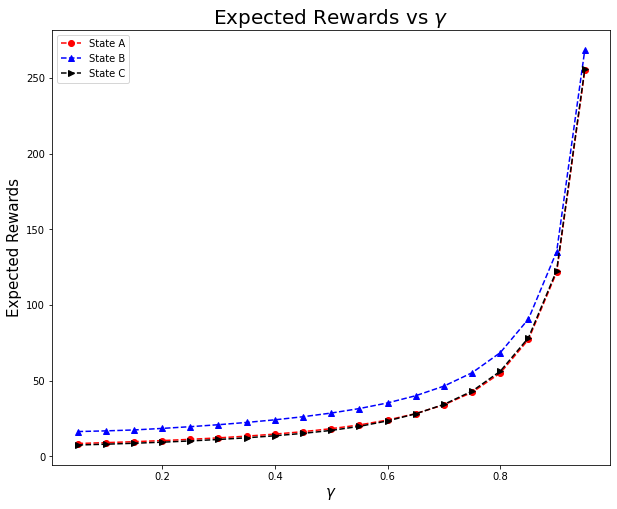

In [19]:
## Visualize policy iteration with multiple values of 
import matplotlib.pyplot as plt
# 1.2 Policy Iteration with different values of gamma
def run_policy_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = policy_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_policy_iteration(env)

rewards = {}
policies = {}
for key in results.keys() :
    rewards[key] = results[key]['Expected Reward']
    policies[key] = results[key]['Policy']

rewards_A = []
rewards_B = []
rewards_C = []

gamma_list = list(results.keys())
for gamma in gamma_list :
    rewards_A.append(rewards[gamma]['A'])
    rewards_B.append(rewards[gamma]['B'])
    rewards_C.append(rewards[gamma]['C'])

plt.title('Expected Rewards vs $\gamma$', fontsize = 20)
plt.plot(gamma_list, rewards_A, marker = 'o', linestyle = "--", color = 'red', label = "State A")
plt.plot(gamma_list, rewards_B, marker = '^', linestyle = "--", color = 'blue', label = "State B")
plt.plot(gamma_list, rewards_C, marker = '>', linestyle = "--", color = 'black', label = "State C")
plt.legend()
plt.xlabel('$\gamma$', fontsize = 15)
plt.ylabel('Expected Rewards', fontsize = 15)
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.show()

# Tabulated policy and reward for each value of $\gamma$

| $\gamma$ = 0.05 | A | B | C |
|---|---|---|---|
| Expected Reward |8.512|16.4|7.499|
| Policy |1|1|1|

___

| $\gamma$ = 0.1 | A | B | C |
|---|---|---|---|
| Expected Reward |9.077|16.856|8.051|
| Policy |1|1|1|

___

| $\gamma$ = 0.15 | A | B | C |
|---|---|---|---|
| Expected Reward |9.708|17.465|8.669|
| Policy |1|2|1|

___

| $\gamma$ = 0.2 | A | B | C |
|---|---|---|---|
| Expected Reward |10.437|18.482|9.384|
| Policy |1|2|1|

___

| $\gamma$ = 0.25 | A | B | C |
|---|---|---|---|
| Expected Reward |11.274|19.63|10.207|
| Policy |1|2|1|

___

| $\gamma$ = 0.3 | A | B | C |
|---|---|---|---|
| Expected Reward |12.244|20.934|11.163|
| Policy |1|2|1|

___

| $\gamma$ = 0.35 | A | B | C |
|---|---|---|---|
| Expected Reward |13.379|22.431|12.283|
| Policy |1|2|1|

___

| $\gamma$ = 0.4 | A | B | C |
|---|---|---|---|
| Expected Reward |14.722|24.167|13.611|
| Policy |1|2|1|

___

| $\gamma$ = 0.45 | A | B | C |
|---|---|---|---|
| Expected Reward |16.334|26.206|15.207|
| Policy |1|2|1|

___

| $\gamma$ = 0.5 | A | B | C |
|---|---|---|---|
| Expected Reward |18.299|28.636|17.156|
| Policy |1|2|1|

___

| $\gamma$ = 0.55 | A | B | C |
|---|---|---|---|
| Expected Reward |20.79|31.607|19.831|
| Policy |1|2|2|

___

| $\gamma$ = 0.6 | A | B | C |
|---|---|---|---|
| Expected Reward |24.026|35.328|23.459|
| Policy |1|2|2|

___

| $\gamma$ = 0.65 | A | B | C |
|---|---|---|---|
| Expected Reward |28.277|40.096|28.13|
| Policy |1|2|2|

___

| $\gamma$ = 0.7 | A | B | C |
|---|---|---|---|
| Expected Reward |34.062|46.435|34.366|
| Policy |1|2|2|

___

| $\gamma$ = 0.75 | A | B | C |
|---|---|---|---|
| Expected Reward |42.317|55.285|43.106|
| Policy |1|2|2|

___

| $\gamma$ = 0.8 | A | B | C |
|---|---|---|---|
| Expected Reward |55.079|68.558|56.27|
| Policy |2|2|2|

___

| $\gamma$ = 0.85 | A | B | C |
|---|---|---|---|
| Expected Reward |77.247|90.812|78.433|
| Policy |2|2|2|

___

| $\gamma$ = 0.9 | A | B | C |
|---|---|---|---|
| Expected Reward |121.653|135.306|122.837|
| Policy |2|2|2|

___

| $\gamma$ = 0.95 | A | B | C |
|---|---|---|---|
| Expected Reward |255.023|268.765|256.203|
| Policy |2|2|2|

___



# Subjective questions


## 1.a How are values of $\gamma$ affecting results of policy iteration

* A higher value of $\gamma$ implies a lower probability of the taxi breaking down. We can see in the plots that the expected rewards tend to increase with higher values of $\gamma$. 
* This is justified as a lower probability of breaking down would imply the taxi driver can keep accumulating rewards for a longer time. 
* From the graph we can also observe that in the limit that $\gamma \rightarrow 1$, the expected rewards would tend to $\infty$. 
* With regards to the policy, we observe that initially, the optimal policy is to take action 1 at all states i.e. to cruise the streets looking for passengers. But as $\gamma$ increases, we see a shift, the optimal policies for each state shifts to 2 i.e. to goto the nearest taxistand and wait in line. 
* This is justified by observing the cost and probability matrices. As action 1 is yields high rewards in the short term it is better to take that action when probability of breakdown is high or consequently $\gamma$ is low. However, action 2 from all three states A, B, C gives a high probability of moving to town B which is profitable in the long term as we have a very high reward in the transition B $\rightarrow^{2}$ B which essentially leads to a high probability chain with a high reward. This action is suitable in the long term when we are ensured that the taxi will not breakdown easily.  

## 1.b For modified policy itetaration, do you find any improvement if you choose m=10.

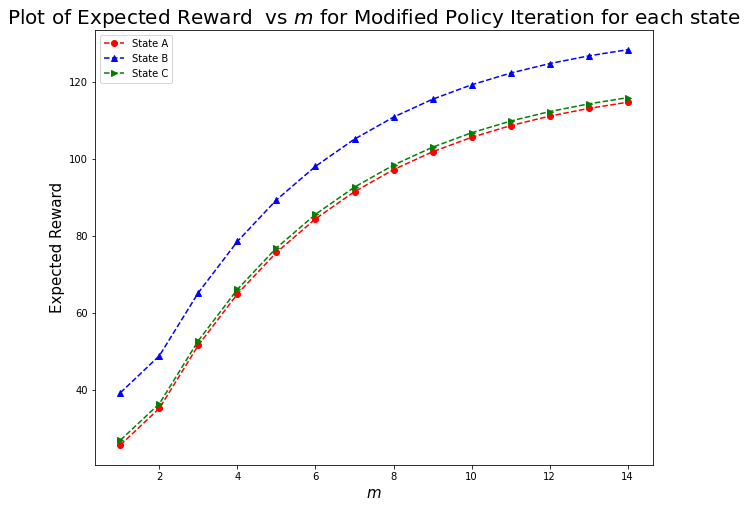

### Observations
* For various values of $m$ ranging from 1 to 15. The optimal policy obtained was the same i.e. with action 2 from each state A, B and C. 
* The expected rewards were different for each value of $m$. The plot above shows the expected reward vs $m$ for each state. 
* From the above plot, we observe that higher values of $m$ (like $m = 10$) lead to a higher value of the expected reward for each state which is a better estimate of the expected reward for the optimal policy. This is because a higher value of $m$ ensures a better estimate of the reward for every intermediate policy obtained and hence a better estimate for the expected reward for the optimal policy.  
* On further increasing $m$, we would obtain even better estimates of the reward for the optimal policy.  

## 1.c Compare and contrast the behavior of Value Iteration and Gauss Seidel Value Iteraton

For the sake of the plots below, consider $\gamma = 0.5$. 

Below we have plots for Values vs Iteration for each of the 3 states A, B, C for both Gauss-Seidel VI and regular VI. 

### Observations 
* For each of the states A, B, and C, we see that the values as obtained by Gauss-Seidel Value Iteration are markedly higher than those obtained by Value Iteration at each iteration/time-stamp
* The plots for both VI and Gauss-Seidel VI plataeu at their expected value. But because of the above observation, we see that for all 3 states Gauss-Seidel VI converges to the expected value quicker (at an earlier iteration) than regulat VI. 
* On repeating the above for $\gamma = 0.1, 0.4, 0.7$ and $0.9$, we can observe similar behaviour. 
* Therefore, we can conclude that in general, Gauss-Seidel VI converges faster than regular VI. 

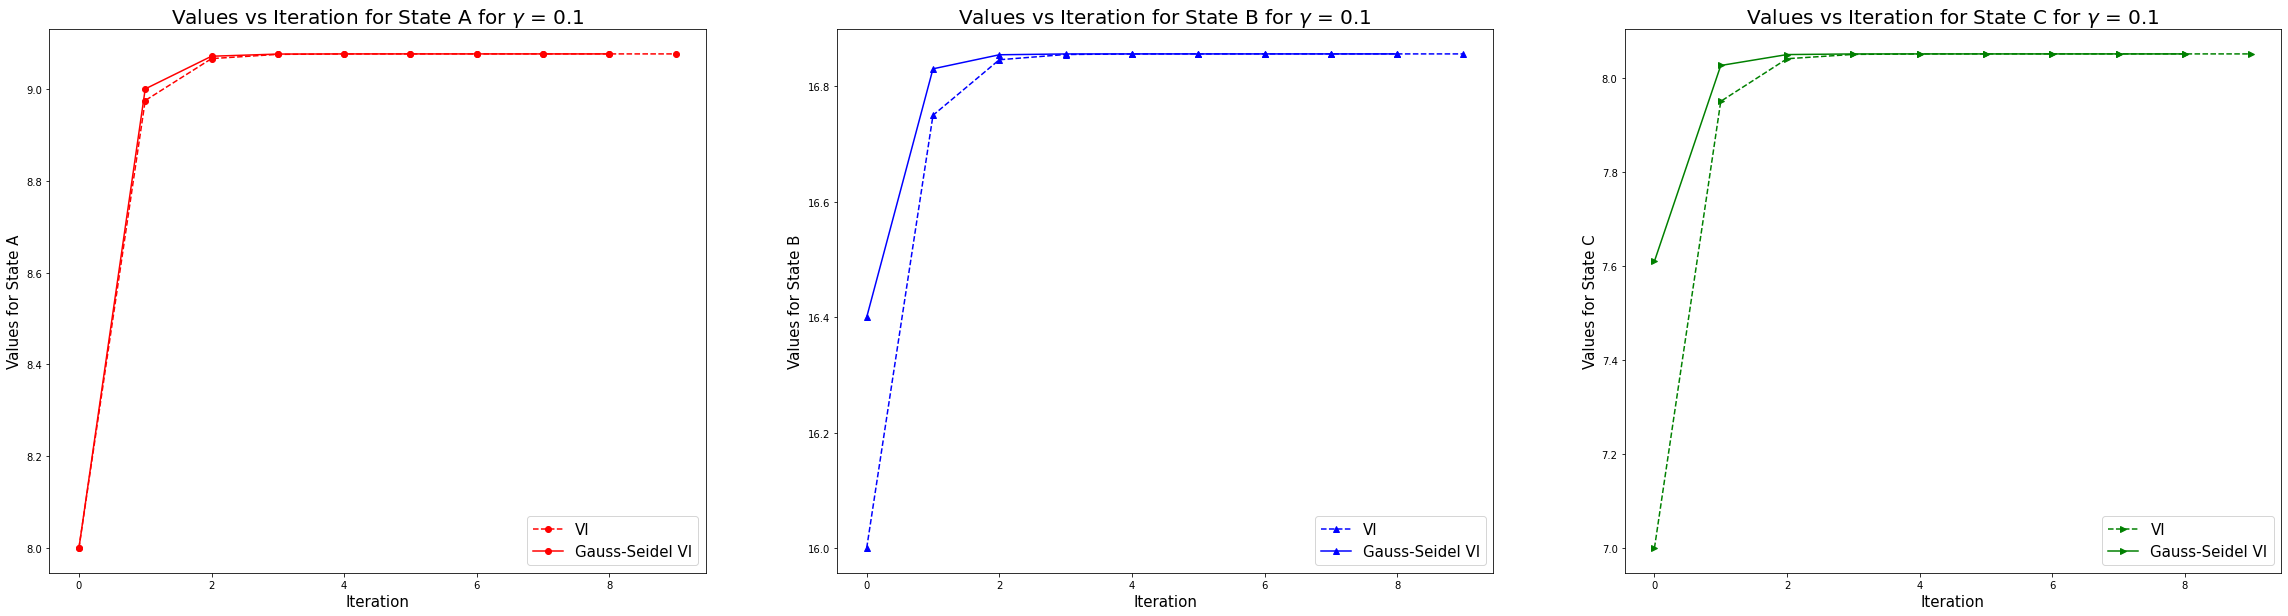

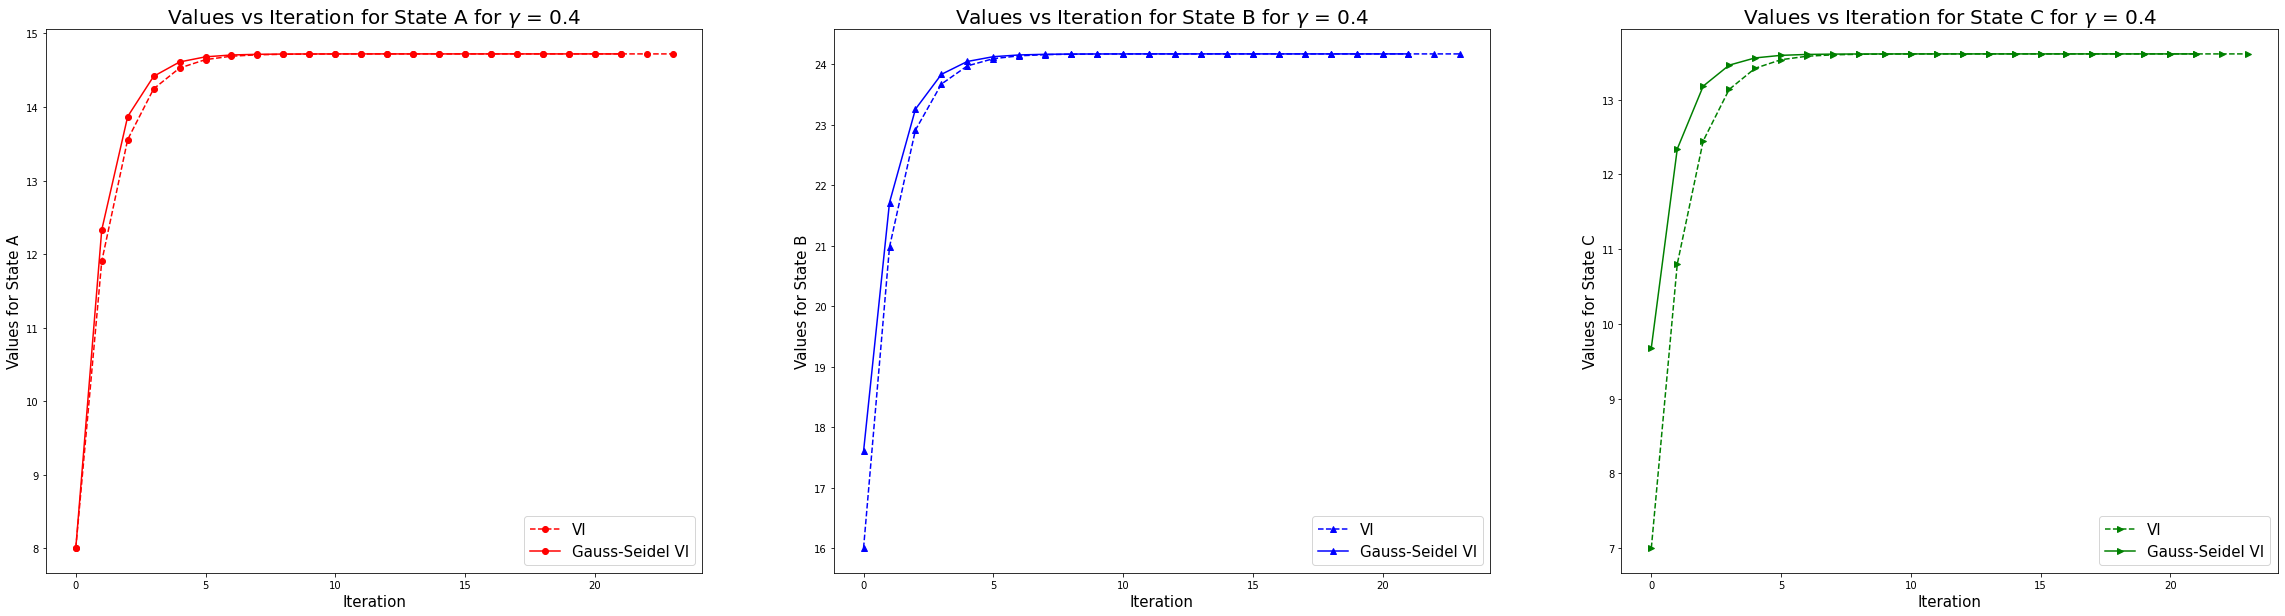

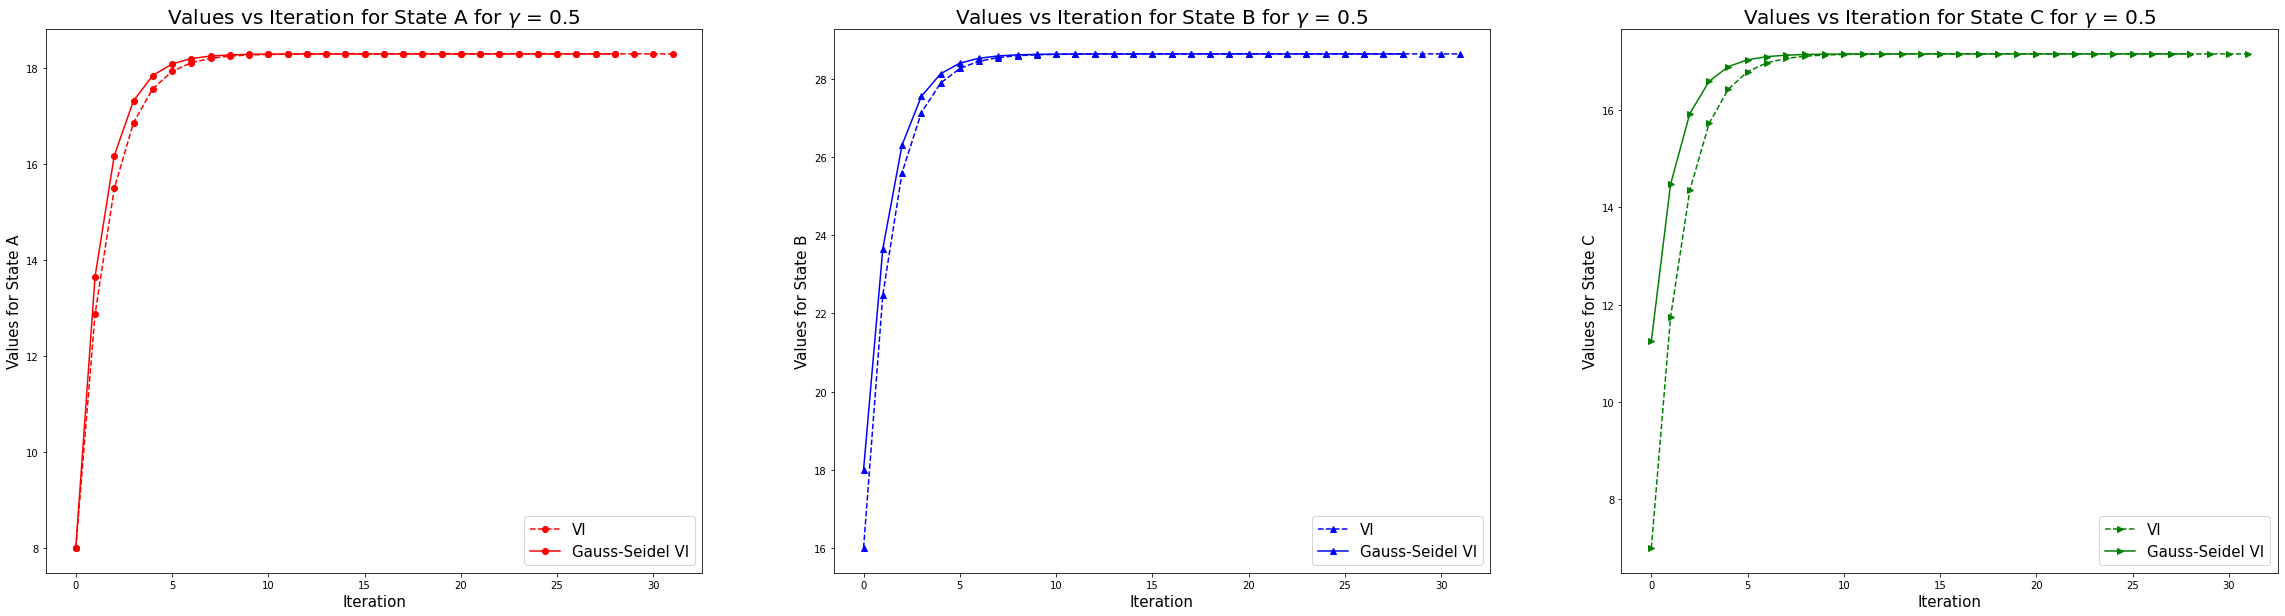

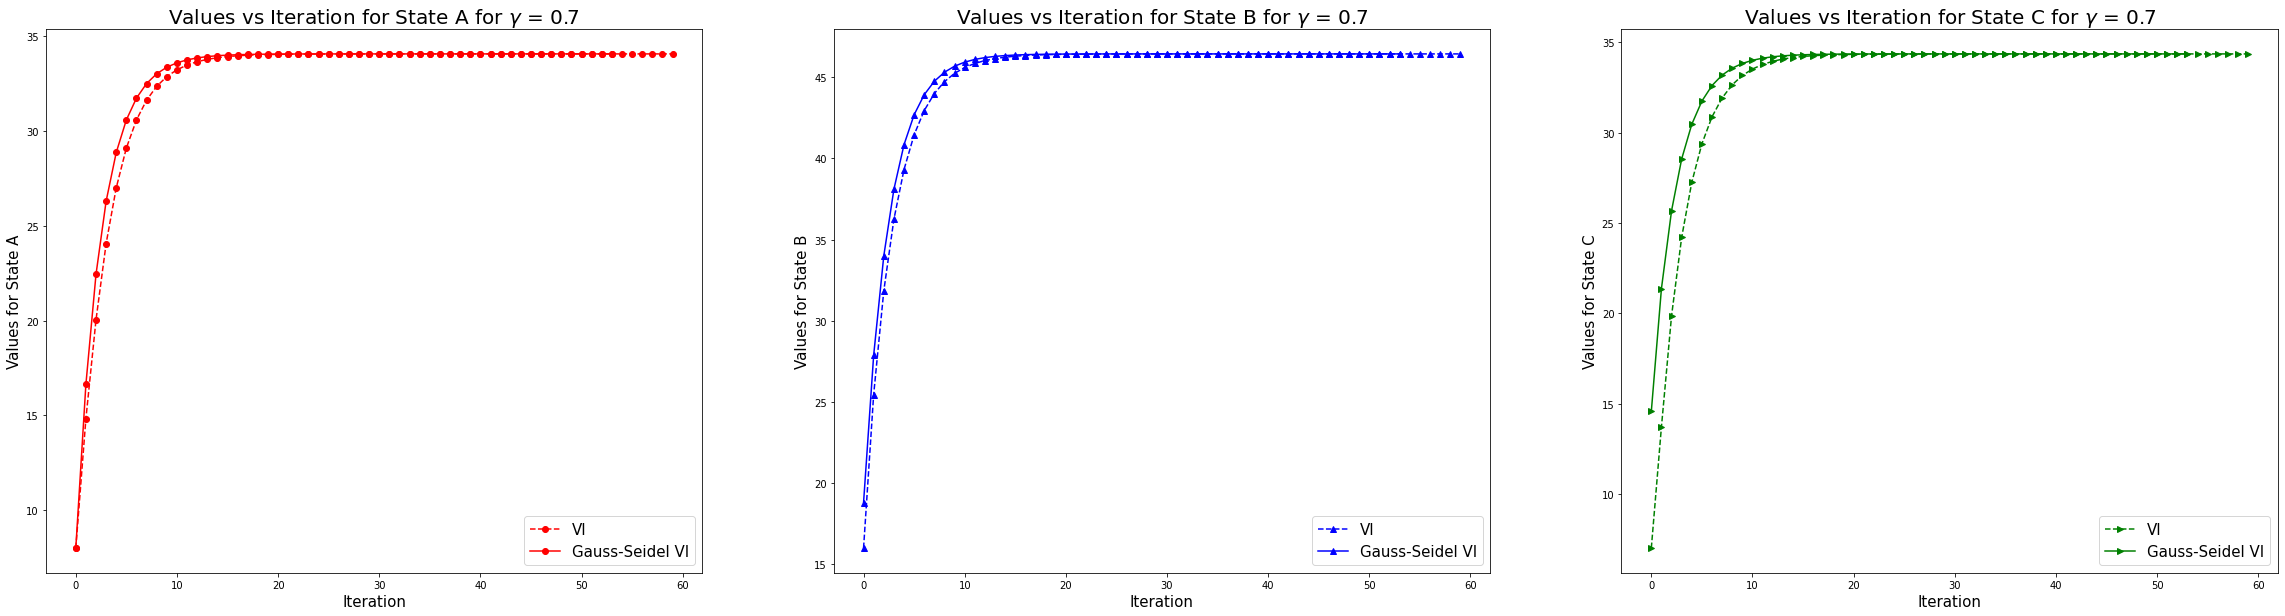

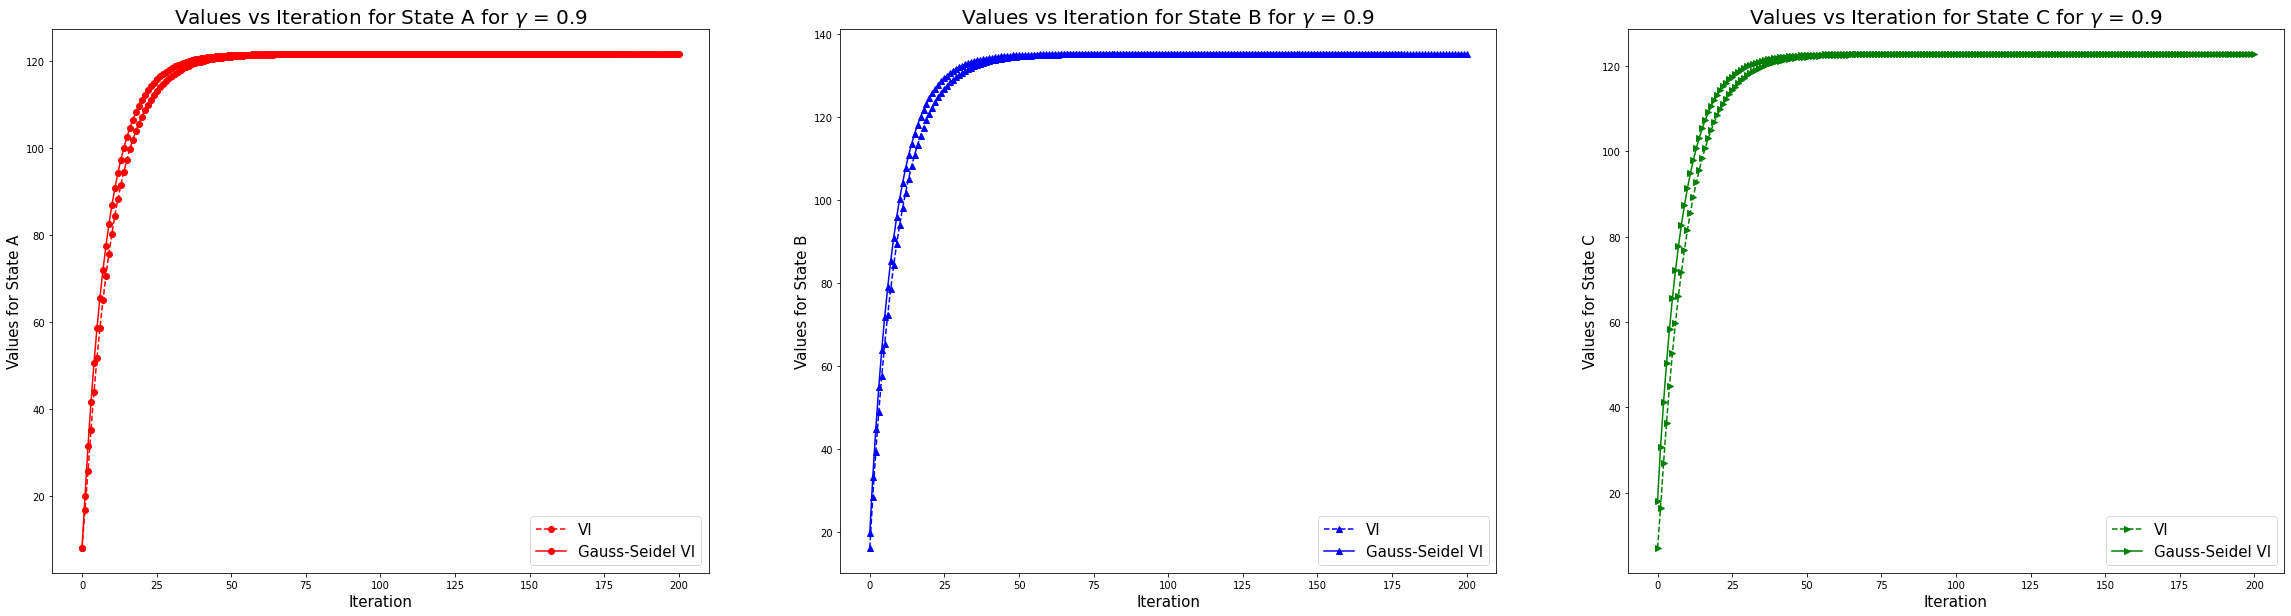

In [20]:
def plotter(gamma) :
    gs_results, gs_extra_info = gauss_seidel_value_iteration(env, gamma)
    results, extra_info = value_iteration(env, gamma)

    gs_value_dict = gs_extra_info['Values_Dict']
    value_dict = extra_info['Values_Dict']

    iteration_value_dict = list(value_dict.keys())
    iteration_gs_value_dict = list(gs_value_dict.keys())

    value = {s: [] for s in ['A', 'B', 'C']}
    gs_value = {s: [] for s in ['A', 'B', 'C']}

    for key in iteration_value_dict :
        for alpha in ['A', 'B', 'C'] :
            value[alpha].append(value_dict[key][alpha])

    for key in iteration_gs_value_dict :
        for alpha in ['A', 'B', 'C'] :
            gs_value[alpha].append(gs_value_dict[key][alpha])

    fig, axs = plt.subplots(1, 3)
    axs[0].plot(iteration_value_dict, value['A'], color = 'red', linestyle = '--', marker = 'o', label = 'VI')
    axs[0].plot(iteration_gs_value_dict, gs_value['A'], color = 'red', linestyle = 'solid', marker = 'o', label = 'Gauss-Seidel VI')
    axs[0].set_xlabel("Iteration", fontsize = 15)
    axs[0].set_ylabel("Values for State A", fontsize = 15)
    axs[0].legend(loc = 'lower right', fontsize = 15)
    axs[0].set_title("Values vs Iteration for State A for $\gamma$ = " + str(gamma), fontsize = 20)

    axs[1].plot(iteration_value_dict, value['B'], color = 'blue', linestyle = '--', marker = '^', label = 'VI')
    axs[1].plot(iteration_gs_value_dict, gs_value['B'], color = 'blue', linestyle = 'solid', marker = '^', label = 'Gauss-Seidel VI')
    axs[1].set_xlabel("Iteration", fontsize = 15)
    axs[1].set_ylabel("Values for State B", fontsize = 15)
    axs[1].legend(loc = 'lower right', fontsize = 15)
    axs[1].set_title("Values vs Iteration for State B for $\gamma$ = " + str(gamma), fontsize = 20)

    axs[2].plot(iteration_value_dict, value['C'], color = 'green', linestyle = 'dashed', marker = '>', label = 'VI')
    axs[2].plot(iteration_gs_value_dict, gs_value['C'], color = 'green', linestyle = 'solid', marker = '>', label = 'Gauss-Seidel VI')
    axs[2].set_xlabel("Iteration", fontsize = 15)
    axs[2].set_ylabel("Values for State C", fontsize = 15)
    axs[2].legend(loc = 'lower right', fontsize = 15)
    axs[2].set_title("Values vs Iteration for State C for $\gamma$ = " + str(gamma), fontsize = 20)

    fig = plt.gcf()
    fig.set_size_inches(40, 10)


"""
def run_modified_policy_iteration(env):
    m_values = np.arange(1, 15)
    gamma = 0.9
    results, extra_info = {}, {}
    for m in m_values:
        results[m], extra_info[m] = modified_policy_iteration(env, gamma, m)
    return results, extra_info

results, extra_info = run_modified_policy_iteration(env)

m_values = list(results.keys())
values = {s:[] for s in ['A', 'B', 'C']}
for m in m_values :
    for alpha in ['A', 'B', 'C'] :
        values[alpha].append(results[m]['Expected Reward'][alpha])

plt.title('Plot of Expected Reward  vs $m$ for Modified Policy Iteration for each state', fontsize = 20)
plt.plot(m_values, values['A'], marker = 'o', linestyle = "--", color = 'red', label = "State A")
plt.plot(m_values, values['B'], marker = '^', linestyle = "--", color = 'blue', label = "State B")
plt.plot(m_values, values['C'], marker = '>', linestyle = "--", color = 'green', label = "State C")
plt.legend()
plt.xlabel('$m$', fontsize = 15)
plt.ylabel('Expected Reward', fontsize = 15)
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.show()
"""
plotter(0.1)
plotter(0.4)
plotter(0.5)
plotter(0.7)
plotter(0.9)




# Submit to AIcrowd 🚀

In [21]:
!DATASET_PATH=$AICROWD_DATASET_PATH aicrowd notebook submit -c iit-m-rl-assignment-2-taxi -a assets

No jupyter lab module found. Using jupyter notebook.
Using notebook: /content/IITM_Assignment_2_Taxi_Release.ipynb for submission...
Removing existing files from submission directory...
No jupyter lab module found. Using jupyter notebook.
Scrubbing API keys from the notebook...
No jupyter lab module found. Using jupyter notebook.
Validating the submission...
Executing install.ipynb...
[NbConvertApp] Converting notebook /content/submission/install.ipynb to notebook
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 1024 bytes to /content/submission/install.nbconvert.ipynb
Executing predict.ipynb...
[NbConvertApp] Converting notebook /content/submission/predict.ipynb to notebook
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
